# Getting Started

## Task 1: Setup Google Cloud Environment

In [40]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set the environment variable
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
# Set the environment variable to the path of your account.json file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'account.json'
PROJECT_ID = os.getenv('PROJECT_ID')
REGION = os.getenv('REGION')
BUCKET = os.getenv('BUCKET')

In [41]:
print(BUCKET)

gs://customer_churn_dataset_staging


## Task 2: Import Libraries

In [3]:
import pandas as pd
import seaborn as sns
from google.cloud import aiplatform
from google.cloud import storage
import io
import os

import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Understand the Data

## Task 3: Load and Analyze the Dataset

In [13]:
# Load the dataset into a pandas DataFrame.
df = pd.read_csv('customer_churn_dataset.csv')

In [5]:
# Display basic information about the features of the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [6]:
# Display the first few rows of the dataset.
df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


## Task 4: Perform Basic Statistical Analysis

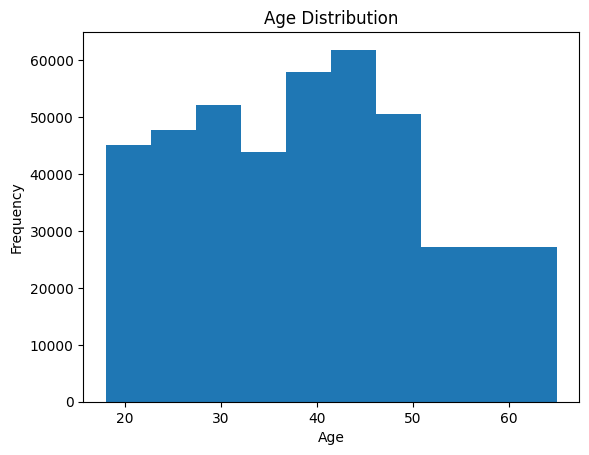

In [7]:
# Histogram of Age: The plot will help you understand the age distribution of customers in the dataset.

import matplotlib.pyplot as plt

plt.hist(df['Age'], bins=10)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()


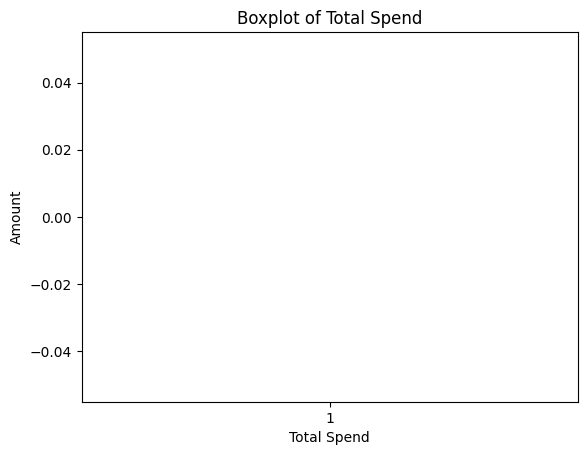

In [8]:
import matplotlib.pyplot as plt

plt.boxplot(df['Total Spend'])
plt.xlabel('Total Spend')
plt.ylabel('Amount')
plt.title('Boxplot of Total Spend')
plt.show()


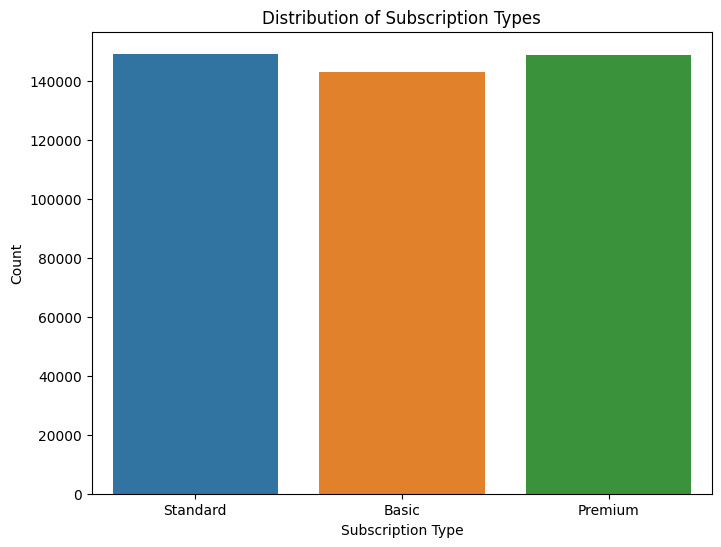

In [9]:
# Countplot of Subscription Type: This will help you understand the distribution of different subscription types among the customers.
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Subscription Type')
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.title('Distribution of Subscription Types')
plt.show()

# Data Preprocessing

## Task 5: Clean and Preprocess the Data

In [14]:
# Removing rows with NaN values
df.dropna(inplace=True)

In [15]:
# Dropping unnecessary columns for model training
df.drop(['CustomerID'], axis=1, inplace=True)

In [16]:
# Removing spaces from feature names
df.columns = df.columns.str.replace(' ', '')

In [43]:
# Define the file path for the preprocessed dataset
file_path = 'data/customer_churn_preprocessed.csv'

# Save the dataframe to a CSV file
# df.to_csv(file_path, index=False)
    
# # Create a storage client
storage_client = storage.Client()

# # Define the GCS bucket name
bucket_name = 'customer_churn_dataset_staging'

# # # Define the destination blob name
blob_name = 'data/customer_churn_preprocessed.csv'

# # # Upload the file to GCS
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(blob_name)
blob.upload_from_filename(file_path)

print(f"Preprocessed dataset uploaded to GCS bucket: {bucket_name}/{blob_name}")


Preprocessed dataset uploaded to GCS bucket: customer_churn_dataset_staging/data/customer_churn_preprocessed.csv


In [44]:
from google.cloud import storage

# Define a new method named upload_dataframe_to_gcs(). In this method, store the preprocessed dataset in the GCS bucket created in Task 1 as the data/customer_churn_preprocessed.csv file.
def upload_dataframe_to_gcs(blob_name, bucket_name):
    # Save the dataframe to a CSV file
    df.to_csv(file_path, index=False)
        
    # Create a storage client
    storage_client = storage.Client()
    
    # Upload the file to GCS
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(blob_name)
    
    print(f"Preprocessed dataset uploaded to GCS bucket: {bucket_name}/{blob_name}")

bucket_name = 'customer_churn_dataset_staging'
file_path = 'data/customer_churn_preprocessed.csv'
upload_dataframe_to_gcs(file_path, bucket_name)

Preprocessed dataset uploaded to GCS bucket: customer_churn_dataset_staging/data/customer_churn_preprocessed.csv


## Task 6: Define Column Transformations

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Age               440832 non-null  float64
 1   Gender            440832 non-null  object 
 2   Tenure            440832 non-null  float64
 3   UsageFrequency    440832 non-null  float64
 4   SupportCalls      440832 non-null  float64
 5   PaymentDelay      440832 non-null  float64
 6   SubscriptionType  440832 non-null  object 
 7   ContractLength    440832 non-null  object 
 8   TotalSpend        440832 non-null  float64
 9   LastInteraction   440832 non-null  float64
 10  Churn             440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 40.4+ MB


In [56]:
column_transformations = [
    {"numeric": {"column_name": "Age"}},
    {"categorical": {"column_name": "Gender"}},
    {"numeric": {"column_name": "Tenure"}},
    {"numeric": {"column_name": "UsageFrequency"}},
    {"numeric": {"column_name": "SupportCalls"}},
    {"numeric": {"column_name": "PaymentDelay"}},
    {"categorical": {"column_name": "SubscriptionType"}},
    {"categorical": {"column_name": "ContractLength"}},
    {"numeric": {"column_name": "TotalSpend"}},
    {"numeric": {"column_name": "LastInteraction"}}
]

# Build and Deploy the Vertex AI AutoML Model 

## Task 7: Prepare the Vertex AI Training Job

In [55]:
# Initialize the aiplatform SDK to use it with your PROJECT_ID and REGION.
# my_dataset = aiplatform.TextDataset.create(
#     display_name="customer_churn")
aiplatform.init(project='dolu-sandbox-408209', location='us-central1')

ds = aiplatform.TabularDataset.create(
    display_name="customer_churn", gcs_source=['gs://customer_churn_dataset_staging/data/customer_churn_preprocessed.csv'])

Creating TabularDataset
Create TabularDataset backing LRO: projects/692127285617/locations/us-central1/datasets/3408361801291661312/operations/349972523896537088
TabularDataset created. Resource name: projects/692127285617/locations/us-central1/datasets/3408361801291661312
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/692127285617/locations/us-central1/datasets/3408361801291661312')


## Task 8: Building the AutoML Model

In [60]:

job = aiplatform.AutoMLTabularTrainingJob(
    display_name="train-churn-automl-1.0",
    optimization_prediction_type="classification",
    column_transformations=column_transformations,
)
model = job.run(
    dataset=ds,
    target_column="Churn",
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    model_display_name="adopted-prediction-model",
    disable_early_stopping=False,
sync=False,)

View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5834950875365244928?project=692127285617
AutoMLTabularTrainingJob projects/692127285617/locations/us-central1/trainingPipelines/5834950875365244928 current state:
PipelineState.PIPELINE_STATE_PENDING
AutoMLTabularTrainingJob projects/692127285617/locations/us-central1/trainingPipelines/5834950875365244928 current state:
PipelineState.PIPELINE_STATE_PENDING
AutoMLTabularTrainingJob projects/692127285617/locations/us-central1/trainingPipelines/5834950875365244928 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/692127285617/locations/us-central1/trainingPipelines/5834950875365244928 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/692127285617/locations/us-central1/trainingPipelines/5834950875365244928 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/692127285617/locations/us-central1/trai

# Deploy and Predict

## Task 9: Load and Evaluate the Model

In [ ]:
model = aiplatform.Model.list()[0]
print(f"Trained model resource name: {model.resource_name}")


In [ ]:
model_evaluations = model.list_model_evaluations()
# Print the evaluation metrics
for evaluation in model_evaluations:
    evaluation = evaluation.to_dict()
    print("Model's evaluation metrics from Training:\n")
    metrics = evaluation["metrics"]
    for metric in metrics.keys():
        print(f"metric: {metric}, value: {metrics[metric]}\n")

## Task 10: Deploy the Classification Model

In [ ]:
churnEndpointTest = aiplatform.Endpoint.create(
    display_name='churnEndpointTest',
    project=f"{PROJECT_ID}",
    location=f"{REGION}",
    endpoint_id='123456',
    sync=False)

In [ ]:
# Deploy the model to the endpoint
model.deploy(endpoint=churnEndpointTest, machine_type="n1-standard-4",
    sync=False)

## Task 11: Make Online Predictions

In [ ]:
#Prepare the endpoint even after the session timeout
endpoint = aiplatform.Endpoint(endpoint_name='churnEndpointTest')
deployed_models = endpoint.list_models()
if not deployed_models:
  print("no models deployed yet")
else:
    for deployed_model in deployed_models:
      
      if deployed_model.display_name == "adopted-prediction-model":
        print ("Model deployed, you can move to prediction phase")

In [ ]:
prediction = endpoint.predict({  
  "Age": "22",
  "Gender": "Female",
  "Tenure": "25",
  "UsageFrequency": "14",  
  "SupportCalls": "4",
  "PaymentDelay": 
  "27",
  "SubscriptionType": "Basic",  
  "ContractLength": "Monthly",  
  "TotalSpend": "598",
  "LastInteraction": "9",
})
prediction

# Cleanup

## Task 12: Clean up the Environnement